In [16]:
import sys
sys.path.append('../..')
from sisyphus2.tasks import rdm as rd
from sisyphus2.backend.models.basic import Basic

import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [17]:
dt = 10 # time-step
tau = 100 # intrinsic time constant of neural state decay
T = 2000 # time to run for (number of steps is T/dt)
N_batch = 50 # number of trials per training step
N_rec = 50 # number of recurrent units
name = 'basicModel'

In [18]:
rdm = rd.RDM(dt = dt, tau = tau, T = T, N_batch = N_batch)

RDM puts the params passed in as well as other generated params into a dict we can then use to create our model. 

In [19]:
params = rdm.__dict__
print(params)

{'tau': 100, 'N_in': 2, 'N_batch': 50, 'T': 2000, 'N_steps': 200, 'alpha': 0.1, 'dt': 10, 'N_out': 2}


Generate *N_batch* trials to be used in training

In [20]:
gen = rdm.batch_generator()

We add in a few params that Basic(RNN) needs but that RDM doesn't generate for us.

In [21]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec

There are some other optional parameters we can add in:

In [22]:
params['dale_ratio'] = None # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0.0 # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None

Instantiate our model

In [23]:
basicModel = Basic(params)

Start a tensorflow session with loss, regularization, predictions, and regularized loss defined.

In [24]:
basicModel.build()

Set the training parameters for our model. All of the parameters below are optional.

In [25]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 10000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True

Train our model.

In [26]:
basicModel.train(gen, train_params)

Iter 500, Minibatch Loss= 0.217171
Iter 1000, Minibatch Loss= 0.144407
Iter 1500, Minibatch Loss= 0.131260
Iter 2000, Minibatch Loss= 0.134487
Iter 2500, Minibatch Loss= 0.125787
Iter 3000, Minibatch Loss= 0.138233
Iter 3500, Minibatch Loss= 0.129716
Iter 4000, Minibatch Loss= 0.127842
Iter 4500, Minibatch Loss= 0.126972
Iter 5000, Minibatch Loss= 0.125414
Iter 5500, Minibatch Loss= 0.112165
Iter 6000, Minibatch Loss= 0.117597
Iter 6500, Minibatch Loss= 0.109692
Iter 7000, Minibatch Loss= 0.087948
Iter 7500, Minibatch Loss= 0.055023
Iter 8000, Minibatch Loss= 0.051424
Iter 8500, Minibatch Loss= 0.024476
Iter 9000, Minibatch Loss= 0.028592
Iter 9500, Minibatch Loss= 0.021172
Optimization finished!
Model saved in file: ../weights/refactor_weights.npz


([0.21717139,
  0.14440705,
  0.13126023,
  0.1344873,
  0.12578748,
  0.13823326,
  0.1297158,
  0.12784182,
  0.12697183,
  0.12541436,
  0.11216495,
  0.11759694,
  0.109692454,
  0.087947816,
  0.05502306,
  0.051423714,
  0.024475697,
  0.028592164,
  0.021171734],
 49.73930311203003,
 20.455734968185425)

### Plot results

Extract the next trial from the generator

In [27]:
x,y,m = gen.next()

Plot the x value of the trial -- for the RDM, this includes two input neurons ith different coherence. TODO(jasmine):x is time step, y is magnitude of input (arbitrary)

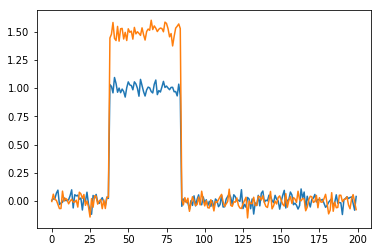

In [28]:
plt.plot(x[0,:,:])

Run the trained model on this trial (not included in the training set).

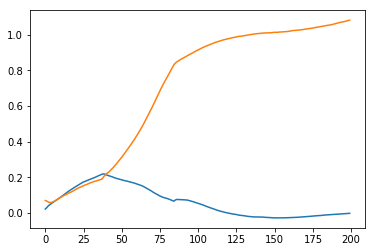

In [29]:
plt.plot(basicModel.test(x)[0][0,:,:])

clean up the model to clear out the tensorflow namespace

In [30]:
basicModel.destruct()